In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import re
from wordcloud import WordCloud

# Trends in InfoNTD/Infolep data
### Data load

In [2]:
df_ntd = pd.read_csv('Datasets/publicationsDatasetInfoPortals.csv')
df_ntd

Unnamed: 0    bib_id     bibcite_type  \
0               0       6.0           thesis   
1               1      34.0  journal_article   
2               2      35.0  journal_article   
3               3      36.0  journal_article   
4               4      37.0  journal_article   
...           ...       ...              ...   
42358       42358  102107.0  journal_article   
42359       42359  102108.0  journal_article   
42360       42360  102109.0  journal_article   
42361       42361  102110.0  journal_article   
42362       42362  102111.0           report   

                                       uuid  \
0      a8d83e03-2a58-4fce-9110-5d57b35c348a   
1      734c3399-ba63-45b9-ac23-f48282a58733   
2      55b5e61a-ffd7-4fb6-974b-e0aab3ee65d9   
3      7ca86ad1-bfb7-4201-8873-3b07edb8a1a6   
4      e392dec7-01bc-49d7-a496-5916a29aef48   
...                                     ...   
42358  d84c760e-547d-4d52-9fe4-f3fab859a4e7   
42359  070947f9-ef5b-4ae8-894c-9d4e51568e75   
42360  1633534f-5cef-4c8a-8fec-7c10458cecc2   
42361  914f6593-9747-470c-897a-c274a9c1531f   
42362  cd5e69d1-5027-4241-8ec5-da6bdd91e0fb   

                                           bibcite_title  bibcite_year  \
0      On the spread of leprosy in a heterogeneous po...        2010.0   
1      The spatial distribution of leprosy cases duri...        2008.0   
2      The spatial distribution of leprosy in four vi...        2008.0   
3      The prevalence of previously undiagnosed lepro...        2008.0   
4      The quality of life, mental health, and percei...        2007.0   
...                                                  ...           ...   
42358  Implementation Research in Low- and Middle-Inc...        2025.0   
42359  Investigating outcomes of female genital schis...        2025.0   
42360  Community-led strategies for communicable dise...        2025.0   
42361  Co-morbidity of malaria and soil-transmitted h...        2025.0   
42362  Mapping the Social Entrepreneurship Landscape ...        2024.0   

                                 bibcite_secondary_title  \
0                                                    NaN   
1                                BMC infectious diseases   
2                                BMC infectious diseases   
3                       PLoS neglected tropical diseases   
4                       Social science & medicine (1982)   
...                                                  ...   
42358                                    Rising Scholars   
42359  Transactions of The Royal Society of Tropical ...   
42360                          PLOS Global Public Health   
42361                     Infectious Diseases of Poverty   
42362                                                NaN   

                                             bibcite_url  \
0                       http://hdl.handle.net/1765/20548   
1      http://www.ncbi.nlm.nih.gov/pmc/articles/PMC25...   
2      http://www.ncbi.nlm.nih.gov/pmc/articles/PMC25...   
3      http://www.ncbi.nlm.nih.gov/pmc/articles/PMC22...   
4                                                    NaN   
...                                                  ...   
42358   https://risingscholars.net/en/news/details/2082/   
42359                                                NaN   
42360  https://journals.plos.org/globalpublichealth/a...   
42361  https://idpjournal.biomedcentral.com/counter/p...   
42362  https://seghana.net/wp-content/uploads/formida...   

                             bibcite_doi  \
0      http://hdl.handle.net/1765/20548    
1                10.1186/1471-2334-8-126   
2                10.1186/1471-2334-8-125   
3           10.1371/journal.pntd.0000198   
4        10.1016/j.socscimed.2007.02.014   
...                                  ...   
42358                                NaN   
42359             10.1093/trstmh/traf006   
42360       10.1371/journal.pgph.0004304   
42361         10.1186/s40249-025-01276-x   
42362                                NaN   

     

In [7]:
print("Entries with abstracts:", df_ntd['bibcite_abst_e__value'].isna().sum())
print("Entries with no abstracts:", df_ntd['bibcite_abst_e__value'].notna().sum())
df_ntd_nona = df_ntd[df_ntd['bibcite_abst_e__value'].notna()]

Entries with abstracts: 16928
Entries with no abstracts: 25435


In [9]:
df_ntd_nona['bibcite_type'].value_counts()

journal_article           23221
report                      756
book_chapter                434
book                        343
thesis                      314
miscellaneous               155
conference_proceedings       43
web_service                  37
web_resource                 26
legal_ruling                 21
journal                      18
fact_sheet                   12
audiovisual                  11
conference_paper              9
web_article                   7
government_report             6
multimedia                    5
website                       5
artwork                       4
presentation                  2
newspaper_article             2
classical                     1
web_project_page              1
magazine_article              1
guidelines                    1
Name: bibcite_type, dtype: int64

In [10]:
df_ntd_nona['bibcite_year'].value_counts()

2024.0    1685
2016.0    1433
2023.0    1390
2020.0    1340
2021.0    1301
          ... 
1912.0       1
1959.0       1
1961.0       1
1933.0       1
1910.0       1
Name: bibcite_year, Length: 89, dtype: int64

### Publication years

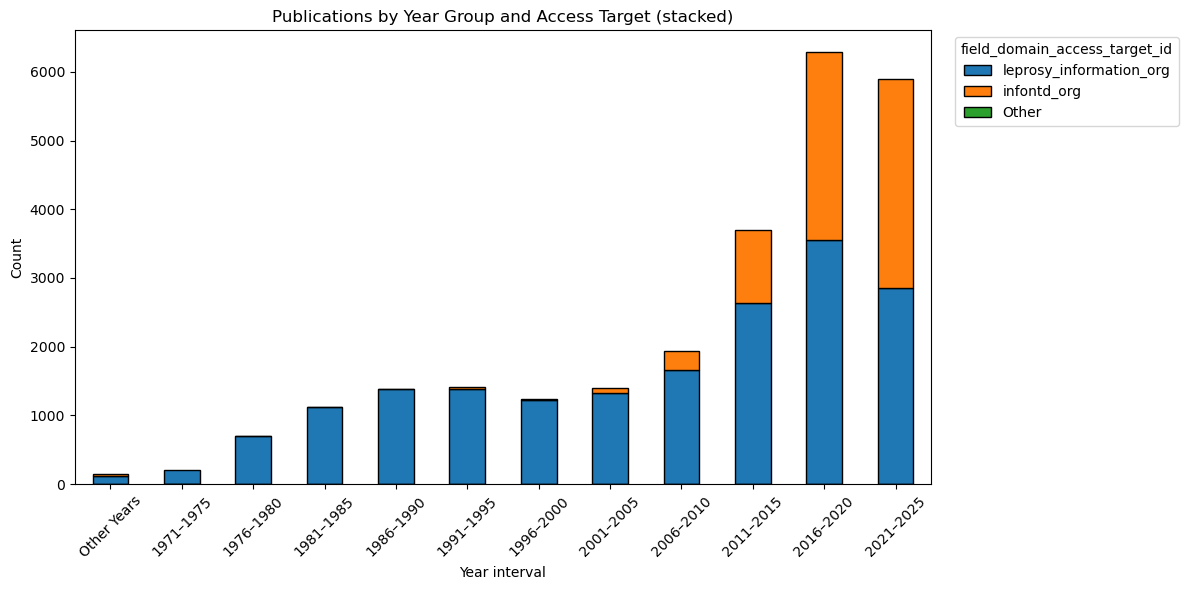

In [64]:

# 1) Copy & build your custom bins
df = df_ntd_nona.copy()
years   = df['bibcite_year']
min_y, max_y = years.min(), years.max()

# 200-year bins up to 1950
start_200 = (min_y // 200) * 200
bins_pre  = np.arange(start_200, 1950, 200)

# 5-year bins from 1950 onward
bins_post = np.arange(1951, max_y + 5, 5)

bins = np.unique(np.concatenate([bins_pre, bins_post]))
labels = [f"{int(bins[i])}–{int(bins[i+1] - 1)}" 
          for i in range(len(bins)-1)]

df['year_group'] = pd.cut(
    df['bibcite_year'],
    bins=bins,
    right=False,
    labels=labels
)

# 2) Group by your year bins & the new column
counts = (
    df
    .groupby(['year_group', 'field_domain_access_target_id'])
    .size()
    .unstack(fill_value=0)
)

# 3) Collapse low-count intervals into "Other Years"
threshold = 100
total_per_interval = counts.sum(axis=1)
low_bins = total_per_interval[total_per_interval < threshold].index

counts_lumped = counts.copy()
counts_lumped.index = counts_lumped.index.where(
    ~counts_lumped.index.isin(low_bins),
    'Other Years'
)
counts_final = counts_lumped.groupby(counts_lumped.index).sum()

# 4) (Optional) Only keep the top N access targets, lump the rest into "Other"
top_n = 5
top_cols = counts_final.sum().sort_values(ascending=False).head(top_n).index.tolist()
others = [c for c in counts_final.columns if c not in top_cols]

counts_final['Other'] = counts_final[others].sum(axis=1)
counts_final = counts_final[top_cols + ['Other']]

# 5) Plot as a stacked bar chart
order = ['Other Years'] + sorted(
    [i for i in counts_final.index if i!='Other Years'],
    key=lambda s: int(s.split('–')[0])
)
counts_final = counts_final.reindex(order)

ax = counts_final.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    edgecolor='black'
)

ax.set_xlabel('Year interval')
ax.set_ylabel('Count')
ax.set_title('Publications by Year Group and Access Target (stacked)')
ax.legend(title='field_domain_access_target_id', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

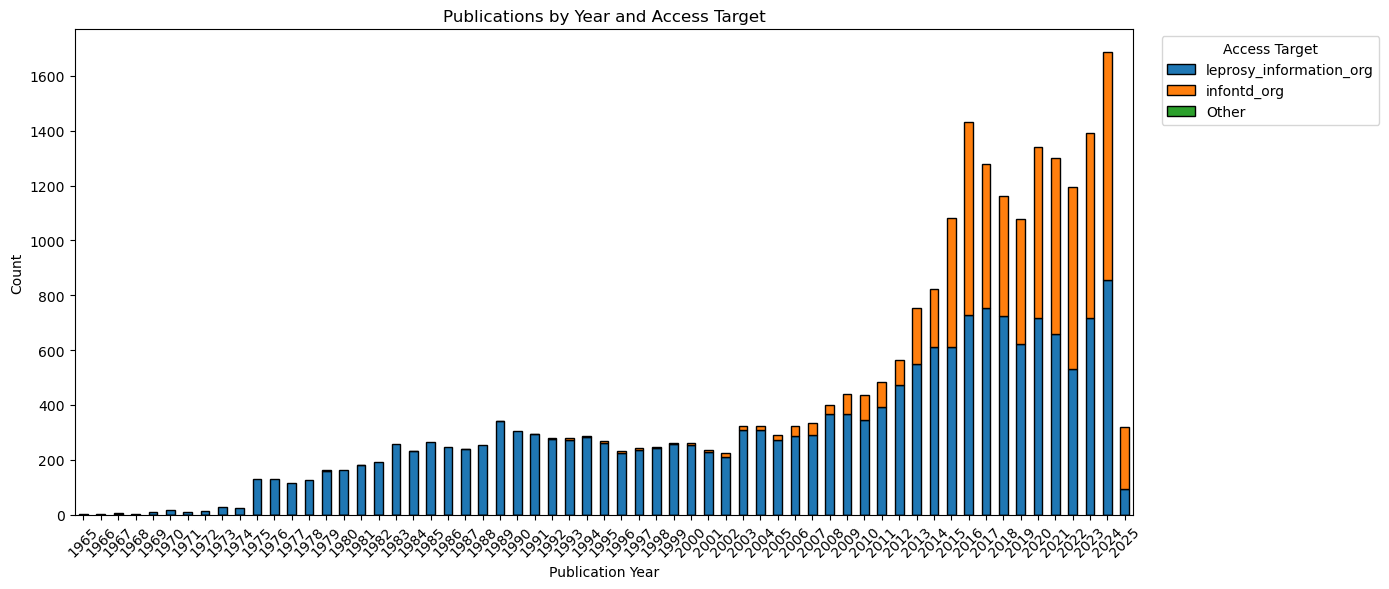

In [71]:
# 1) Copy and filter out years below 300
df = df_ntd_nona.copy()
df['bibcite_year'] = (
    pd.to_numeric(df['bibcite_year'], errors='coerce')
      .astype('Int64')
)
df = df[df['bibcite_year'] >= 1965]

# 2) Group by single year & access target, pivot to wide form
counts_per_year = (
    df
    .groupby(['bibcite_year', 'field_domain_access_target_id'])
    .size()
    .unstack(fill_value=0)
)

# 3) (Optional) Keep only top N access targets + lump the rest
top_n = 5
top_cols = counts_per_year.sum().sort_values(ascending=False).head(top_n).index.tolist()
other_cols = [c for c in counts_per_year.columns if c not in top_cols]

counts_per_year['Other'] = counts_per_year[other_cols].sum(axis=1)
counts_per_year = counts_per_year[top_cols + ['Other']]

# 4) Plot as a stacked bar chart
ax = counts_per_year.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    edgecolor='black'
)

ax.set_xlabel('Publication Year')
ax.set_ylabel('Count')
ax.set_title('Publications by Year and Access Target')
ax.legend(title='Access Target', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Disease distribution

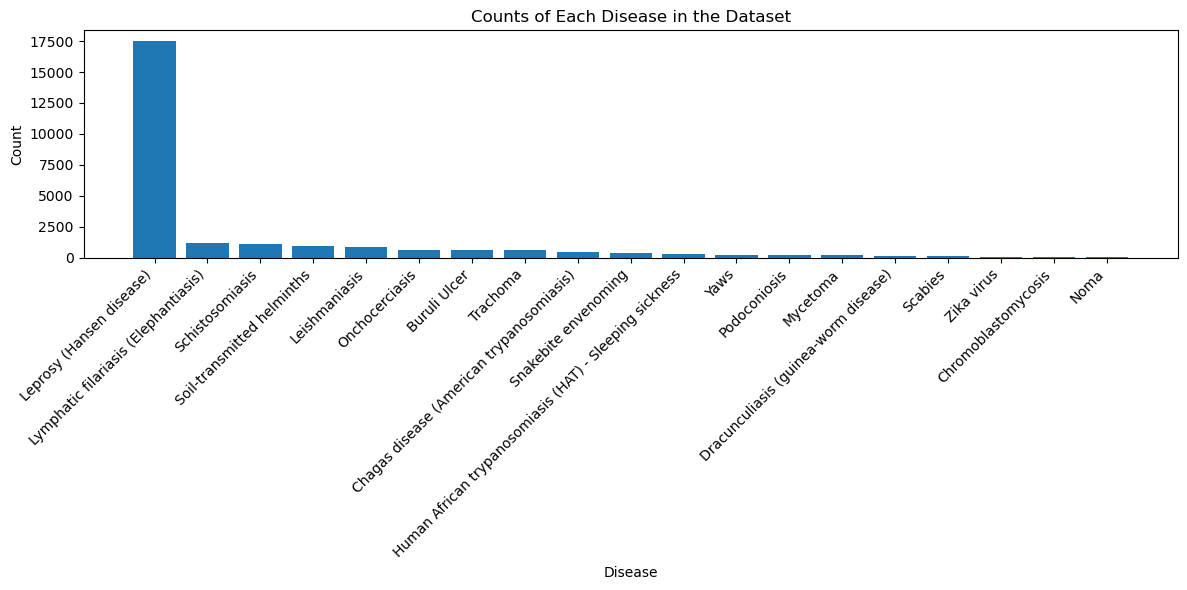

In [27]:
# 1) Flatten the 'Disease' column into a list of diseases
disease_list = []
for cell in df_ntd_nona['Disease']:
    if pd.isna(cell):
        continue
    # parse stringified lists back to Python lists
    if isinstance(cell, str):
        try:
            items = ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            continue
    elif isinstance(cell, list):
        items = cell
    else:
        continue
    disease_list.extend(items)

# 2) Count each disease
counts = pd.Series(disease_list).value_counts()

# 3) Sort descending (optional, for nicer bars left-to-right)
counts = counts.sort_values(ascending=False)

# 4) Plot with matplotlib (no custom colors)
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values)
plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Counts of Each Disease in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

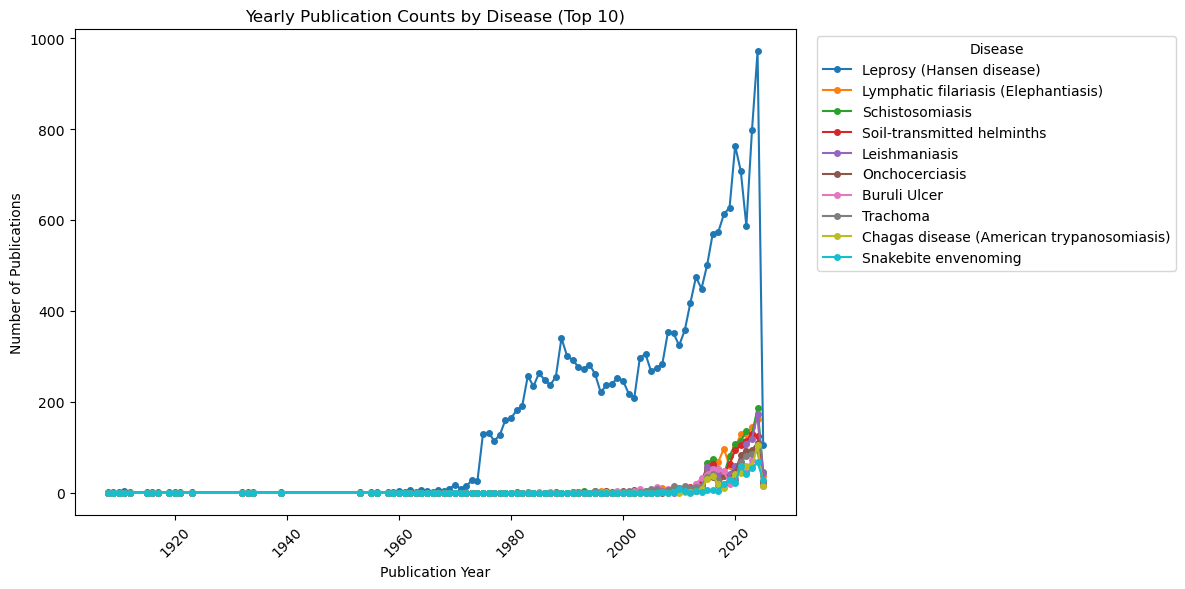

In [30]:
# 1) Parse Diseases into lists
def parse_diseases(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, list):
        return cell
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            return []
    return []

df = df_ntd_nona.copy()
df['disease_list'] = df['Disease'].apply(parse_diseases)

# 2) Explode to one (year, disease) per row
df_exp = (
    df[['bibcite_year', 'disease_list']]
      .explode('disease_list')
      .dropna(subset=['disease_list'])
)

# 3) Filter out outlier years < 300
df_exp = df_exp[df_exp['bibcite_year'] >= 300]

# 4) Pivot to get yearly counts by disease
yearly_counts = (
    df_exp
      .groupby(['bibcite_year', 'disease_list'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# 5) Select top N diseases overall
top_n = 10
top_diseases = yearly_counts.sum().nlargest(top_n).index
yearly_top = yearly_counts[top_diseases]

# 6) Plot lines with smaller markers
plt.figure(figsize=(12, 6))
for disease in top_diseases:
    plt.plot(
        yearly_top.index,
        yearly_top[disease],
        marker='o',
        markersize=4,
        linestyle='-',
        label=disease
    )

plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')
plt.title('Yearly Publication Counts by Disease (Top 10)')
plt.legend(title='Disease', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

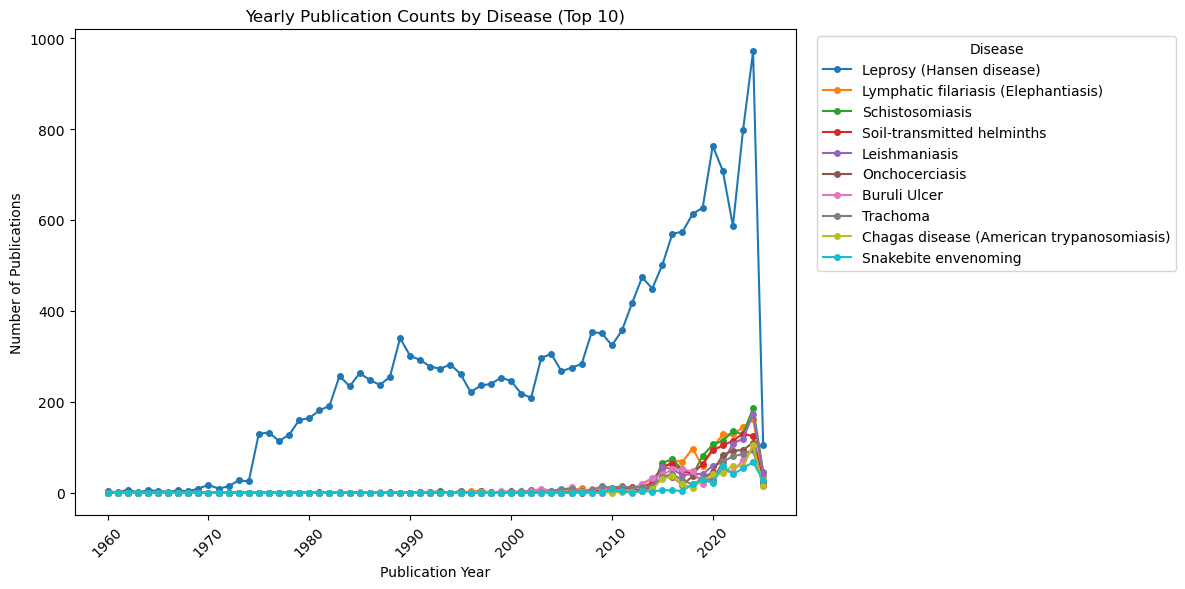

In [72]:
# 1) Parse Diseases into lists
def parse_diseases(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, list):
        return cell
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            return []
    return []

df = df_ntd_nona.copy()
df['disease_list'] = df['Disease'].apply(parse_diseases)

# 2) Explode to one (year, disease) per row
df_exp = (
    df[['bibcite_year', 'disease_list']]
      .explode('disease_list')
      .dropna(subset=['disease_list'])
)

# 3) Filter out outlier years < 300
df_exp = df_exp[df_exp['bibcite_year'] >= 1960]

# 4) Pivot to get yearly counts by disease
yearly_counts = (
    df_exp
      .groupby(['bibcite_year', 'disease_list'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# 5) Select top N diseases overall
top_n = 10
top_diseases = yearly_counts.sum().nlargest(top_n).index
yearly_top = yearly_counts[top_diseases]

# 6) Plot lines with smaller markers
plt.figure(figsize=(12, 6))
for disease in top_diseases:
    plt.plot(
        yearly_top.index,
        yearly_top[disease],
        marker='o',
        markersize=4,
        linestyle='-',
        label=disease
    )

plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')
plt.title('Yearly Publication Counts by Disease (Top 10)')
plt.legend(title='Disease', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

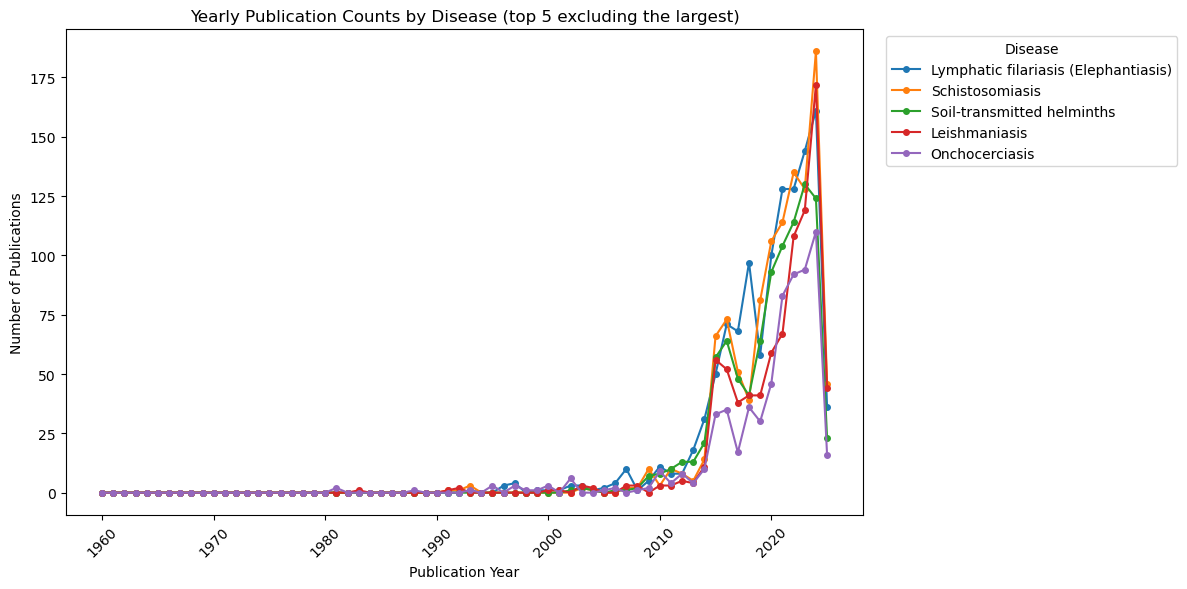

In [75]:

# 1) Parse Diseases into lists
def parse_diseases(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, list):
        return cell
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            return []
    return []

df = df_ntd_nona.copy()
df['disease_list'] = df['Disease'].apply(parse_diseases)

# 2) Explode to one (year, disease) per row
df_exp = (
    df[['bibcite_year', 'disease_list']]
      .explode('disease_list')
      .dropna(subset=['disease_list'])
)

# 3) Filter out outlier years < 300 (or use your 1960 cutoff)
df_exp = df_exp[df_exp['bibcite_year'] >= 1960]

# 4) Pivot to get yearly counts by disease
yearly_counts = (
    df_exp
      .groupby(['bibcite_year', 'disease_list'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# 5) Pick top N diseases but exclude the very largest one
top_n = 5
totals = yearly_counts.sum(axis=0).sort_values(ascending=False)

# drop the overall largest
totals = totals.drop(totals.index[0])

# now take the next top_n
top_diseases = totals.head(top_n).index.tolist()

yearly_top = yearly_counts[top_diseases]

# 6) Plot lines for those top N (excluding the largest)
plt.figure(figsize=(12, 6))
for disease in top_diseases:
    plt.plot(
        yearly_top.index,
        yearly_top[disease],
        marker='o',
        markersize=4,
        linestyle='-',
        label=disease
    )

plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')
plt.title(f'Yearly Publication Counts by Disease (top {top_n} excluding the largest)')
plt.legend(title='Disease', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Regions

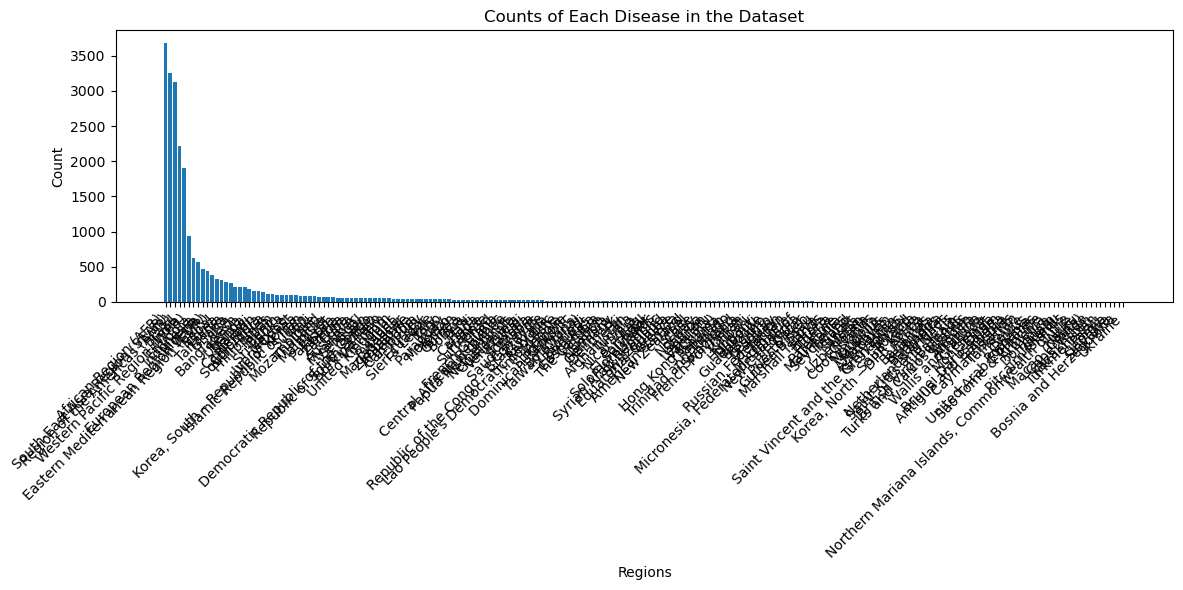

In [77]:
# 1) Flatten the 'Disease' column into a list of diseases
disease_list = []
for cell in df_ntd_nona['Type4']:
    if pd.isna(cell):
        continue
    # parse stringified lists back to Python lists
    if isinstance(cell, str):
        try:
            items = ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            continue
    elif isinstance(cell, list):
        items = cell
    else:
        continue
    disease_list.extend(items)

# 2) Count each disease
counts = pd.Series(disease_list).value_counts()

# 3) Sort descending (optional, for nicer bars left-to-right)
counts = counts.sort_values(ascending=False)

# 4) Plot with matplotlib (no custom colors)
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values)
plt.xlabel('Regions')
plt.ylabel('Count')
plt.title('Counts of Each Disease in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

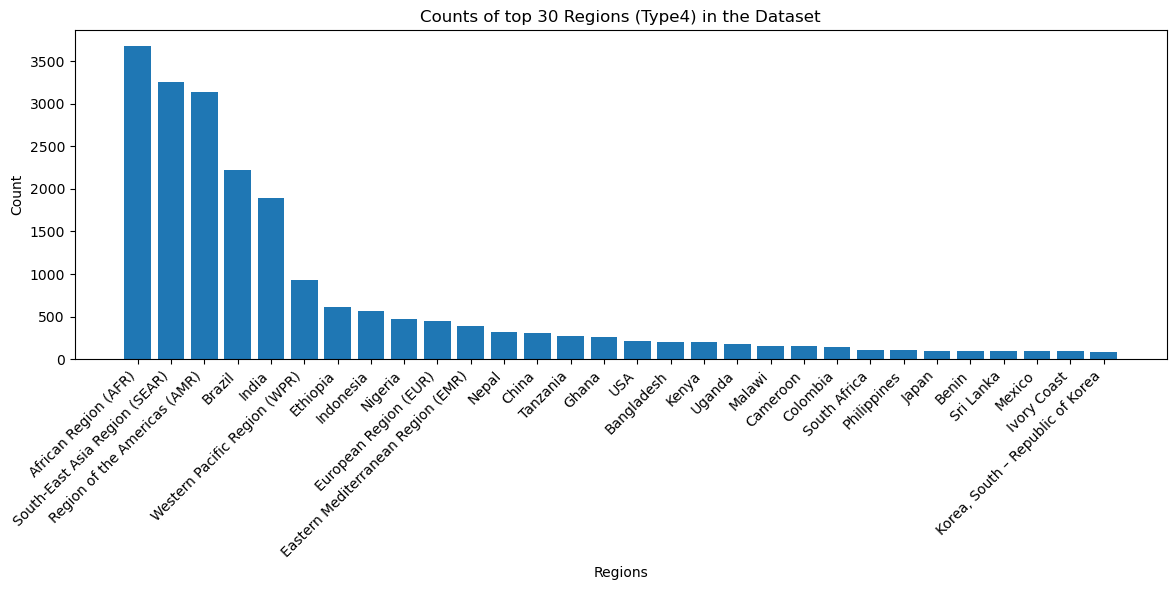

In [82]:
# 1) Flatten the 'Disease' column into a list of diseases
disease_list = []
for cell in df_ntd_nona['Type4']:
    if pd.isna(cell):
        continue
    # parse stringified lists back to Python lists
    if isinstance(cell, str):
        try:
            items = ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            continue
    elif isinstance(cell, list):
        items = cell
    else:
        continue
    disease_list.extend(items)

# 2) Count each disease
counts = pd.Series(disease_list).value_counts()

# 3) Sort descending (optional, for nicer bars left-to-right)
counts = counts.sort_values(ascending=False)

counts = counts[:30]

# 4) Plot with matplotlib (no custom colors)
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values)
plt.xlabel('Regions')
plt.ylabel('Count')
plt.title('Counts of top 30 Regions (Type4) in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Cross-cutting issues

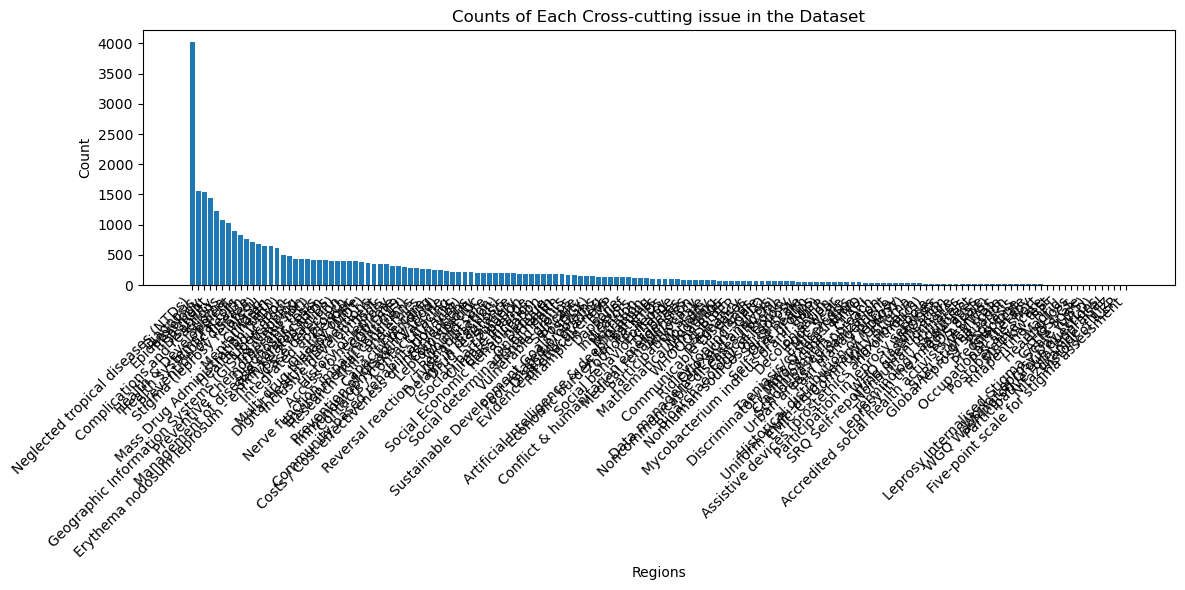

In [84]:
# 1) Flatten the 'Disease' column into a list of diseases
disease_list = []
for cell in df_ntd_nona['Type3']:
    if pd.isna(cell):
        continue
    # parse stringified lists back to Python lists
    if isinstance(cell, str):
        try:
            items = ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            continue
    elif isinstance(cell, list):
        items = cell
    else:
        continue
    disease_list.extend(items)

# 2) Count each disease
counts = pd.Series(disease_list).value_counts()

# 3) Sort descending (optional, for nicer bars left-to-right)
counts = counts.sort_values(ascending=False)

# 4) Plot with matplotlib (no custom colors)
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values)
plt.xlabel('Regions')
plt.ylabel('Count')
plt.title('Counts of Each Cross-cutting issue in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

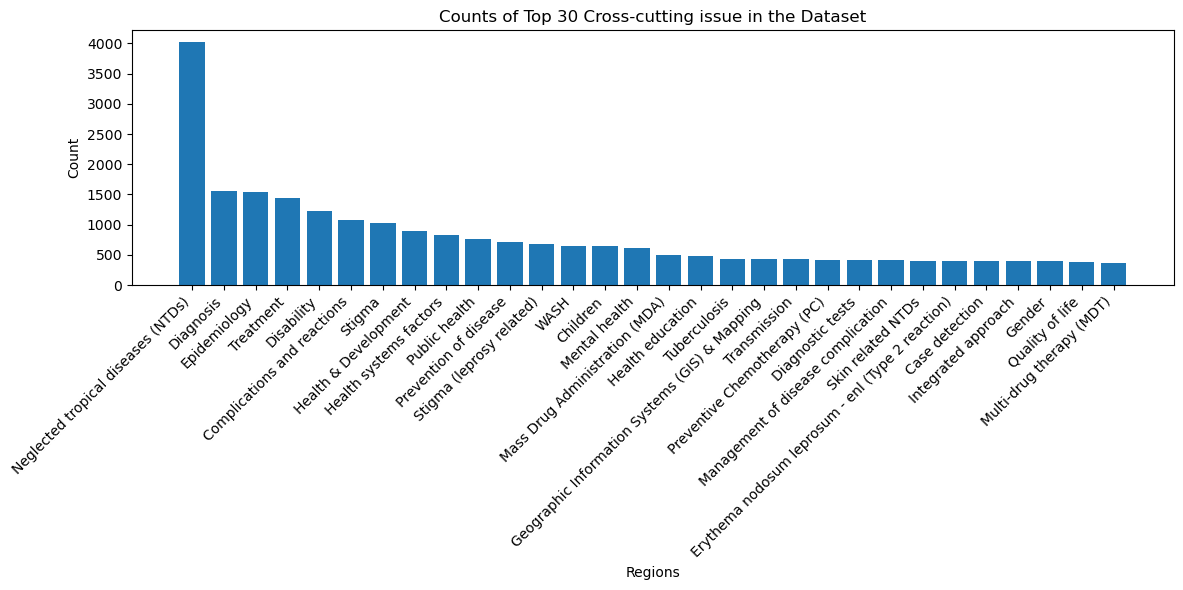

In [86]:
# 1) Flatten the 'Disease' column into a list of diseases
disease_list = []
for cell in df_ntd_nona['Type3']:
    if pd.isna(cell):
        continue
    # parse stringified lists back to Python lists
    if isinstance(cell, str):
        try:
            items = ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            continue
    elif isinstance(cell, list):
        items = cell
    else:
        continue
    disease_list.extend(items)

# 2) Count each disease
counts = pd.Series(disease_list).value_counts()

# 3) Sort descending (optional, for nicer bars left-to-right)
counts = counts.sort_values(ascending=False)
counts = counts[:30]
# 4) Plot with matplotlib (no custom colors)
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values)
plt.xlabel('Regions')
plt.ylabel('Count')
plt.title('Counts of Top 30 Cross-cutting issue in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Keywords

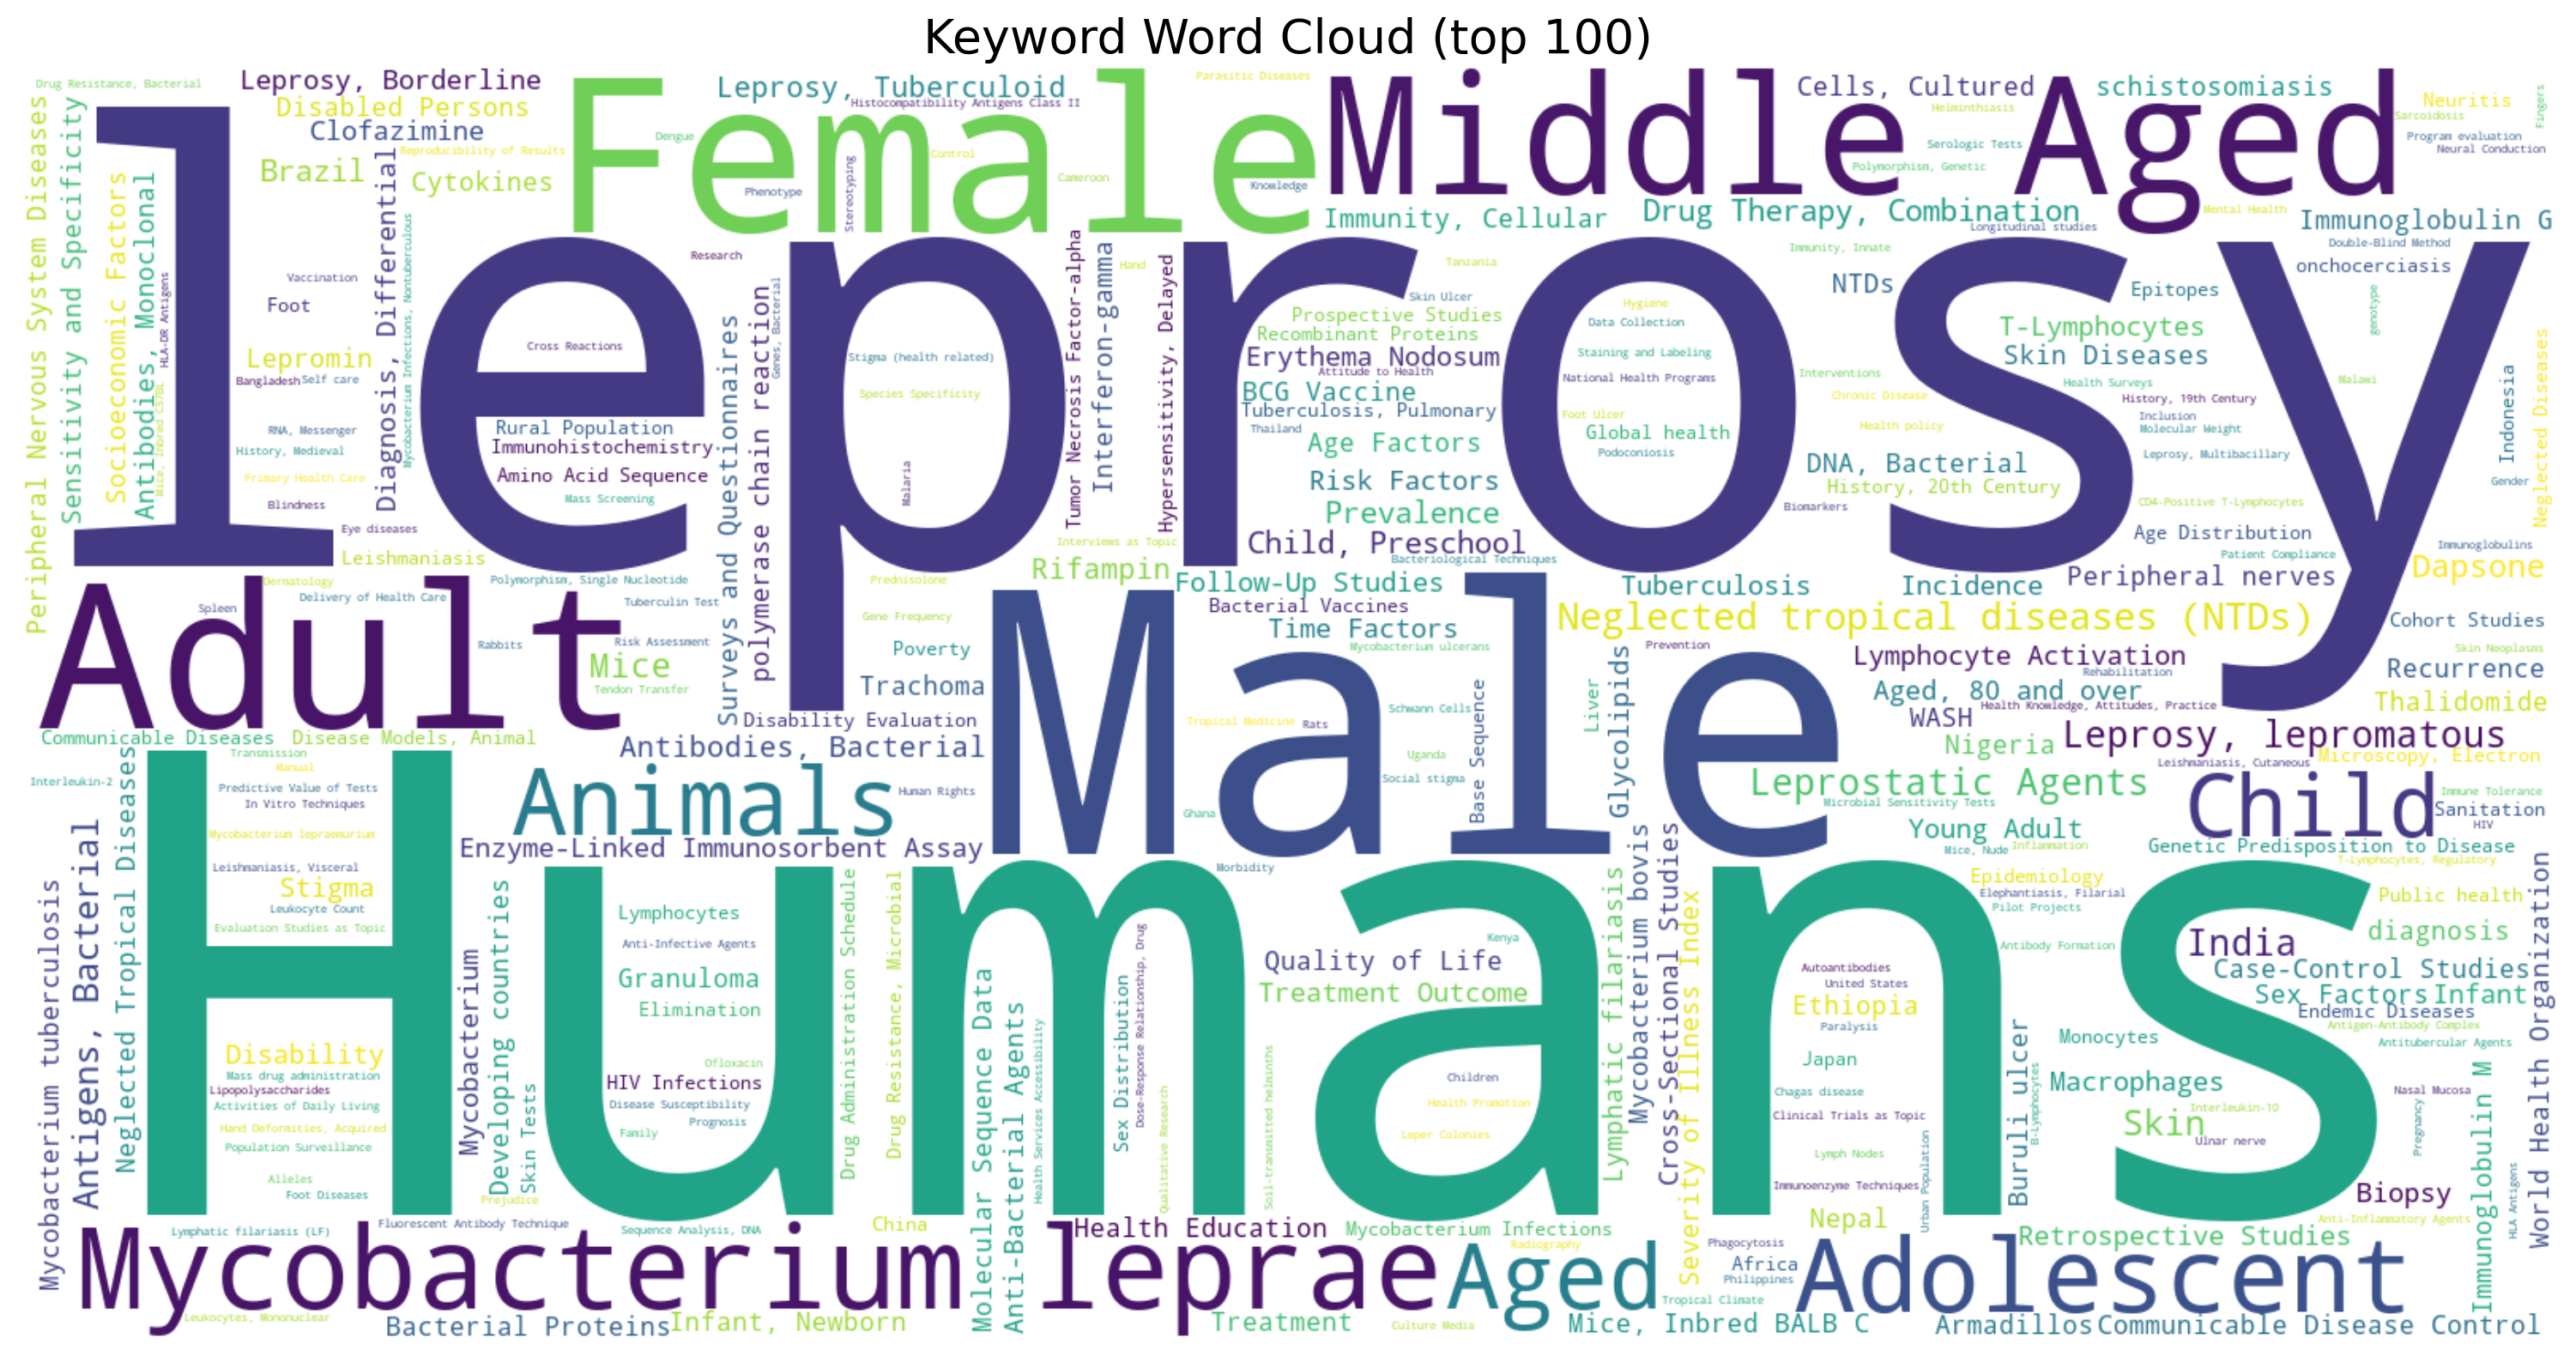

In [100]:
# 1) Helper to parse your Keywords cell into a Python list
def parse_keywords(cell):
    if pd.isna(cell):
        return []
    # If it’s already a list, just return it
    if isinstance(cell, list):
        return cell
    # If it’s a string, try to literal_eval; otherwise fallback to splitting on common delimiters
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            # e.g. "kw1; kw2, kw3" or "kw1,kw2"
            parts = re.split(r'[;,]', cell)
            return [p.strip() for p in parts if p.strip()]
    return []

# 2) Copy & parse into a new list-column
df = df_ntd_nona.copy()
df['keyword_list'] = df['Keywords'].apply(parse_keywords)

# 3) Explode so each row is one keyword
df_kw = (
    df[['keyword_list']]
      .explode('keyword_list')
      .dropna(subset=['keyword_list'])
)

# 4) Count frequencies
kw_counts = df_kw['keyword_list'].value_counts()

# 5) Build & display the word cloud
#    (you can adjust width/height/background_color as you like)
wc = WordCloud(
    width=1600,            # double the width
    height=800,            # double the height
    max_words=300,         # show at most 100 words
    background_color='white',
    random_state=2137
)

wc.generate_from_frequencies(kw_counts.to_dict())

# 6) Plot at high DPI for sharpness
plt.figure(figsize=(16, 8), dpi=200)  # DPI=200 gives much sharper output
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud (top 100)', fontsize=20)
plt.tight_layout()
plt.show()

# PubMed data

# Article co-occurence